In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyreadstat
import seaborn as sns
import scipy.stats as stats #
import statsmodels.api as sm

In [2]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리 가져온다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 지정하기
plt.rcParams['font.family'] = 'Malgun Gothic'

### 데이터 불러오기

In [3]:
raw = pd.read_csv('D:/song/python_practice/welfare/welfare.csv',
                  index_col = 0)
raw.head()

df = raw.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16256 entries, 0 to 16255
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   h17_merkey       16256 non-null  float64
 1   pid              16256 non-null  float64
 2   inhouse_num      16256 non-null  float64
 3   relation         16256 non-null  float64
 4   sex              16256 non-null  float64
 5   birth            16256 non-null  float64
 6   edu              16256 non-null  float64
 7   edu_detail       16256 non-null  float64
 8   disable_type     16256 non-null  float64
 9   disable_degree   16256 non-null  float64
 10  marriage         16256 non-null  float64
 11  religion         16256 non-null  int64  
 12  live_together    16256 non-null  float64
 13  industry         8372 non-null   float64
 14  job              8372 non-null   float64
 15  inc_regular      2928 non-null   float64
 16  inc_temp         4175 non-null   float64
 17  inc_owner        

# EDA

### 성별과 월급
    - 성별 : sex - 1/남성, 2/여성
    - 성별 : sex_factor - male / female

    - 소득 : inc

In [5]:
count_sex = df.sex_factor.value_counts().to_frame()
count_sex

,count
sex_factor,
female,8971
male,7285


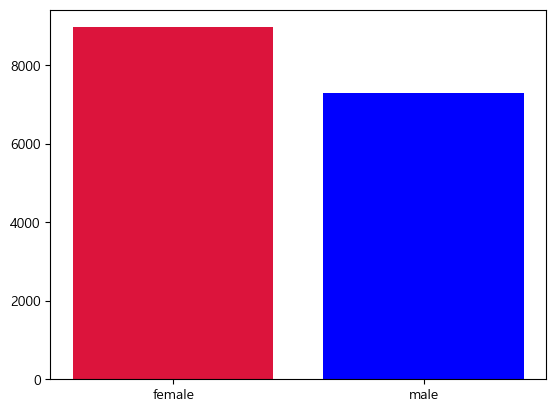

In [6]:
plt.bar(count_sex.index, count_sex['count'], color = ['crimson', 'b'])
plt.xticks(rotation = 0)
plt.xlabel(None)
plt.show()

In [7]:
df.inc.describe()

count    7659.000000
mean     2605.595900
std      2078.524839
min        11.000000
25%       800.000000
50%      2319.000000
75%      3781.500000
max      8910.000000
Name: inc, dtype: float64

In [8]:
count_inc = df['inc'].value_counts().to_frame().sort_values('inc')
count_inc

,count
inc,
11.0,1
20.0,1
24.0,1
25.0,1
27.0,4
...,...
8885.0,1
8890.0,1
8896.0,1


In [9]:
df.inc.info()

<class 'pandas.core.series.Series'>
Index: 16256 entries, 0 to 16255
Series name: inc
Non-Null Count  Dtype  
--------------  -----  
7659 non-null   float64
dtypes: float64(1)
memory usage: 254.0 KB


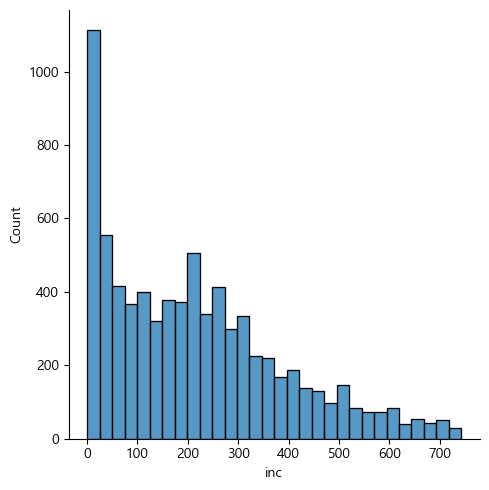

In [10]:
sns.displot(df.inc / 12)
plt.show()

In [11]:
df.groupby('sex_factor')['inc'].agg('mean').round(2)

sex_factor
female    1890.00
male      3342.62
Name: inc, dtype: float64

In [12]:
sex_inc = df.groupby('sex_factor')[['inc']].agg('mean').round(2)
sex_inc

,inc
sex_factor,
female,1890.00
male,3342.62


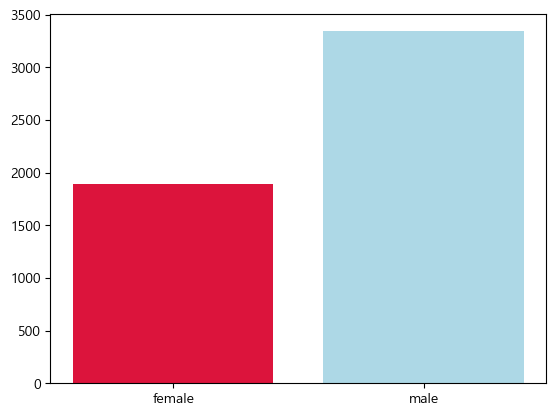

In [13]:
plt.bar(sex_inc.index, sex_inc.inc, color = ['crimson', 'lightblue'])
plt.show()

In [14]:
# 성별에 따른 inc - (t - test 결과)

ttest1, ttest1_p = stats.ttest_ind(df.inc[(df['sex'] == 1) & (df.inc.isna() == False)],
                                                 df.inc[(df['sex'] == 2) & (df.inc.isna() == False)],
                                                 equal_var=True)
print('t-value :', round(ttest1, 2))
print('p-value :', round(ttest1_p, 2))
print('성별에 따른 임금의 차이가 존재한다.')

t-value : 32.63
p-value : 0.0
성별에 따른 임금의 차이가 존재한다.


### 나이와 월급의 관계
- 나이와 소득간의 관계를 확인하기 위해
- 나이를 생산가능연령으로 제한 (15 <= age < 65)
- 나이와 소득은 양의 관계(상관, 회귀 모두)

In [15]:
df.age.info() 
# null 값 미존재

<class 'pandas.core.series.Series'>
Index: 16256 entries, 0 to 16255
Series name: age
Non-Null Count  Dtype
--------------  -----
16256 non-null  int64
dtypes: int64(1)
memory usage: 254.0 KB


In [16]:
df.age.unique()

array([ 78,  75,  81,  61,  60,  20,  96,  83,  53,  31,  82,  45,  48,
        19,  15,  59,  62,  37,  71,  38,  39,  41,   3,  52,  80,  51,
        49,  17,  69,  50,  87,  55,  47,  13,  11,  86,  64,  28,  56,
        25,  68,  65,  29,  24,  16,  73,  67,  93,  85,  32,  34,  26,
        66,  76,  43,  63,  40,  77,  58,  22,  35,  36,  10,   6,  27,
        90,  70,  33,  42,  46,  23,  21,  84,   9,   7,  74,  57,  54,
        98,  44,  14,  12,  89,   8,   4,  91,  72,  79,   5,  30,  88,
        18, 106,  97,   2,  94,  92, 102, 101,  95, 104,  99, 103, 100,
       117], dtype=int64)

In [17]:
inc_condition = (df['inc'].isna() == False)
df_inc_condition = df[inc_condition]# inc가 nan인 경우 제외한 df
df_inc_nonan = df_inc_condition[(df_inc_condition['age'] >= 15) & (df_inc_condition['age'] < 65)] # 생산가능연령만 표시

In [18]:
df_inc_nonan[['age', 'inc']].corr()

,age,inc
age,1.000000,0.088002
inc,0.088002,1.000000


In [19]:
corr1, corr1_p = stats.pearsonr(df_inc_nonan['age'], df_inc_nonan['inc'])
corr2, corr2_p = stats.pearsonr(df_inc_nonan['age'], df_inc_nonan['inc_log'])
print('age - inc의 상관관계 - corr1')
print('corr1 - 상관계수 :', round(corr1, 2))
print('corr1 - pvalue :', round(corr1_p, 2))
print('age - inc 상관관계 - 유의')
print('')
print('age - inc_log의 상관관계 - corr2')
print('corr2 - 상관계수 :', round(corr2, 2))
print('corr2 - pvalue :', round(corr2_p, 2))
print('age - inc 상관관계 - 유의')
print('')

age - inc의 상관관계 - corr1
corr1 - 상관계수 : 0.09
corr1 - pvalue : 0.0
age - inc 상관관계 - 유의

age - inc_log의 상관관계 - corr2
corr2 - 상관계수 : 0.1
corr2 - pvalue : 0.0
age - inc 상관관계 - 유의



In [20]:
corr_df = [[corr1, corr1_p], [corr2, corr2_p]]
corr_df = pd.DataFrame(corr_df,
                       index = ['inc_age','inc(log)_age'],  
                       columns = ['상관계수', 'p-value']).round(3)
corr_df['유의도'] = corr_df['p-value'].apply(lambda x: 'X' if x >= 0.05 else '*' if 0.01 <= x < 0.05 else '**')
corr_df

,상관계수,p-value,유의도
inc_age,0.088,0.0,**
inc(log)_age,0.100,0.0,**


In [21]:
# inc ~ age 의 단순회귀분석
y = df_inc_nonan['inc']
x = df_inc_nonan['age']
x = sm.add_constant(x) # 상수항 추가

reg1 = sm.OLS(y, 
              x)
reg1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    inc   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     42.51
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           7.68e-11
Time:                        15:33:54   Log-Likelihood:                -49228.
No. Observations:                5448   AIC:                         9.846e+04
Df Residuals:                    5446   BIC:                         9.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2546.7041    107.766     23.632      0.000    2335.439    2757.969
age           14.9529      2.294      6.520      0.000      10.457      19.449
==============================================================================
Omnibus:                      302.401   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              341.909
Skew:                           0.599   Prob(JB):                     5.69e-75
Kurtosis:                       2.730   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# inc_log ~ age 의 단순회귀분석
y = df_inc_nonan['inc_log']
x = df_inc_nonan['age']
x = sm.add_constant(x) # 상수항 추가

reg1 = sm.OLS(y, 
              x)
reg1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                inc_log   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     54.72
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.60e-13
Time:                        15:33:54   Log-Likelihood:                -7079.7
No. Observations:                5448   AIC:                         1.416e+04
Df Residuals:                    5446   BIC:                         1.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4563      0.047    158.462      0.000       7.364       7.549
age            0.0074      0.001      7.397      0.000       0.005       0.009
==============================================================================
Omnibus:                     1241.934   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2687.298
Skew:                          -1.314   Prob(JB):                         0.00
Kurtosis:                       5.221   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### 위의 결과에 따라 inc와 age는 양의 상관관계

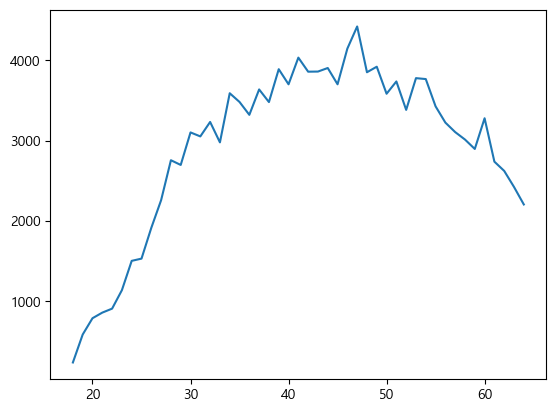

In [23]:
age_inc = df_inc_nonan.groupby('age')[['inc','inc_log']].agg('mean')

plt.plot(age_inc.index, age_inc['inc'])
plt.show()

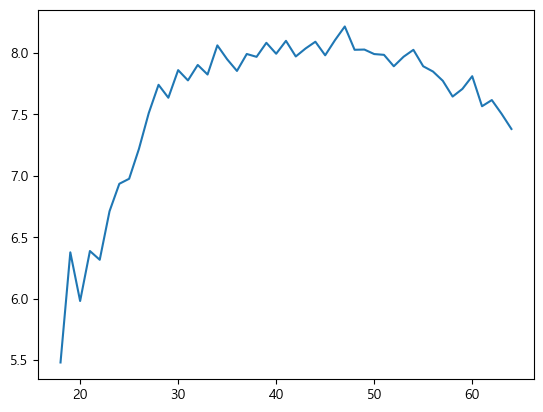

In [24]:
plt.plot(age_inc.index, age_inc['inc_log'])
plt.show()

##### 그래프 결과 2차항의 가능성이 보인다.


In [25]:
# inc ~ age + age^2
y = df_inc_nonan['inc']
x = df_inc_nonan['age']
x = sm.add_constant(x) # 상수항 추가
x['age^2'] = x['age'] ** 2

reg1 = sm.OLS(y, 
              x)
reg1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    inc   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     384.6
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          5.67e-157
Time:                        15:33:54   Log-Likelihood:                -48889.
No. Observations:                5448   AIC:                         9.778e+04
Df Residuals:                    5445   BIC:                         9.780e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6518.0186    352.425    -18.495      0.000   -7208.912   -5827.125
age          462.1224     16.791     27.522      0.000     429.205     495.039
age^2         -5.0950      0.190    -26.854      0.000      -5.467      -4.723
==============================================================================
Omnibus:                      221.667   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.182
Skew:                           0.524   Prob(JB):                     7.78e-55
Kurtosis:                       2.969   Cond. No.                     3.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# 변곡점 b / -2a
b = reg1.fit().params['age']
a = reg1.fit().params['age^2']

print('변곡점은 ', round(-(b/(a * 2)), 2), '세로 예상된다', sep = '')

변곡점은 45.35세로 예상된다


### 연령대와 임금
- 연령대 
    - 30세 미만 young
    - 60세 미만 middle
    - 60세 이상 old

In [27]:
# df_inc_nonan -> inc - non NaN data
df['age_factor'] = df['age'].apply(lambda x: 'young' if x < 30 else 
                                   'middle' if 30 <= x < 60 else 'old')

count_age_factor = df['age_factor'].value_counts().to_frame()
count_age_factor


,count
age_factor,
old,7917
middle,5230
young,3109


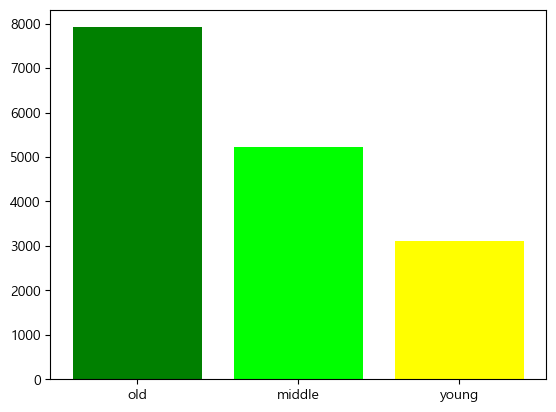

In [28]:
plt.bar(count_age_factor.index, count_age_factor['count'], color = ['g', 'lime', 'yellow'])
plt.show()

In [29]:
### 연령대별 임금분석
# inc non & age group에 따라 구분되는 함수
def age_groupping(df, group):
    globals()['age_' + str(group)] = pd.DataFrame(df[(df['age_factor'] == group) & (df['inc'].isna() == False)]['inc'])
    globals()['age_' + str(group)]['age_factor'] = group

# 결과물은 age_old / age_middle / age_young

In [32]:
age_groupping(df, 'old')
age_groupping(df, 'middle')
age_groupping(df, 'young')

age_group = pd.concat([age_old, age_middle, age_young])
age_group

,inc,age_factor
1,2064.0,old
2,1200.0,old
3,3216.0,old
4,1680.0,old
7,324.0,old
...,...,...
16033,3600.0,young
16142,2602.0,young
16143,2738.0,young
16185,1200.0,young


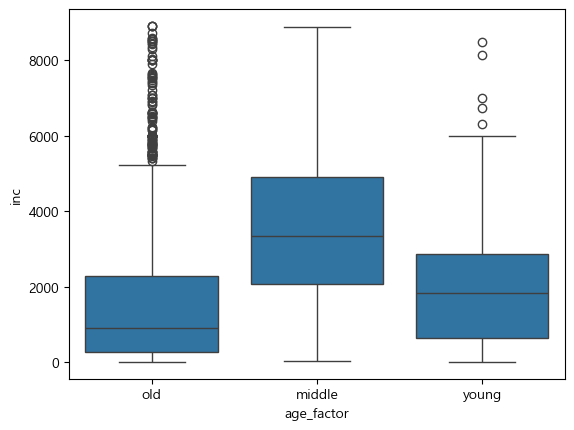

In [33]:
sns.boxplot(data = age_group, 
            x = age_group['age_factor'],
            y = age_group['inc'])
plt.show()

In [34]:
# 3집단의 차이를 보기 위해서는 ANOVA
# https://jae-eun-ai.tistory.com/49
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [35]:
age_inc_anova = ols('inc ~ C(age_factor)', age_group).fit()
print(anova_lm(age_inc_anova))
# 임금에 있어서 
# age_factor간의 차이 존재

                   df        sum_sq       mean_sq            F  PR(>F)
C(age_factor)     2.0  7.892465e+09  3.946232e+09  1199.277573     0.0
Residual       7656.0  2.519213e+10  3.290508e+06          NaN     NaN


##### old와 young의 outlier을 제거하고 나서도 차이가 존재할까?

In [36]:
def delete_outlier(df, group):
    temp = df[df.age_factor == group]['inc']

    IQR = temp.quantile(0.75) - temp.quantile(0.25)
    Q3 = temp.quantile(0.75)
    Q1 = temp.quantile(0.25)

    globals()['age_' + str(group) + '2'] = pd.DataFrame(temp[(temp < (Q3 + (1.5 * IQR))) & (temp > (Q1 - (1.5 * IQR)))])
    globals()['age_' + str(group) + '2']['age_factor'] = group

In [37]:
delete_outlier(df, 'old')
delete_outlier(df, 'middle')
delete_outlier(df, 'young')

In [38]:
age_group2 = pd.DataFrame(pd.concat([age_old2, age_middle2, age_young2]))
age_group2

,inc,age_factor
1,2064.0,old
2,1200.0,old
3,3216.0,old
4,1680.0,old
7,324.0,old
...,...,...
16033,3600.0,young
16142,2602.0,young
16143,2738.0,young
16185,1200.0,young


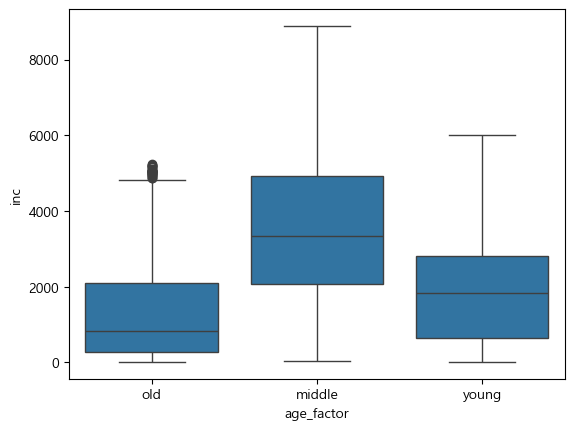

In [39]:
sns.boxplot(data = age_group2, 
            x = age_group2.age_factor,
            y = age_group2.inc)
plt.show()

In [40]:
age_inc_anova2 = ols('inc ~ C(age_factor)', age_group2).fit()
print(anova_lm(age_inc_anova2))
# 임금에 있어서 (outlier를 제외하고도)
# age_factor간의 차이 존재

                   df        sum_sq       mean_sq            F  PR(>F)
C(age_factor)     2.0  9.103097e+09  4.551548e+09  1563.570651     0.0
Residual       7545.0  2.196347e+10  2.910996e+06          NaN     NaN


# 연령대와 성별 - 임금

In [144]:
df2 = df_inc_nonan
df2['age_factor'] = df2['age'].apply(lambda x: 'young' if x < 30 else 
                                     'middle' if 30 <= x < 60 else 'old')


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_12208\1554121973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['age_factor'] = df2['age'].apply(lambda x: 'young' if x < 30 else


In [63]:
inc_age_sex = df2.groupby(['sex_factor', 'age_factor'])[['inc']].agg('mean')
inc_age_sex.reindex(['male', 'female'])

,inc
male,NaN
female,NaN


In [79]:
inc_sex_age = df2.groupby(['age_factor', 'sex_factor'])[['inc']].agg('mean')
inc_sex_age.index.to_flat_index

<bound method MultiIndex.to_flat_index of MultiIndex([('middle', 'female'),
            ('middle',   'male'),
            (   'old', 'female'),
            (   'old',   'male'),
            ( 'young', 'female'),
            ( 'young',   'male')],
           names=['age_factor', 'sex_factor'])>

<Axes: xlabel='age_factor'>

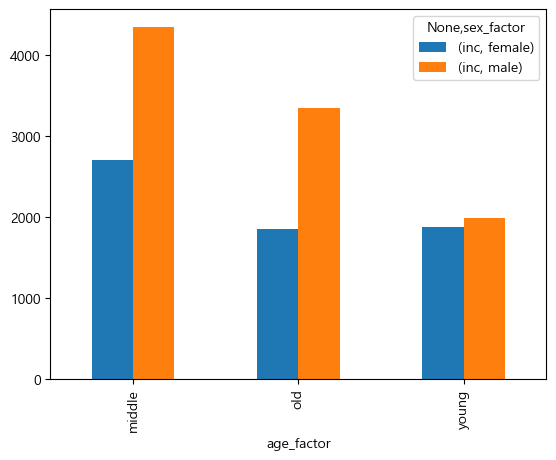

In [92]:
df2.groupby(['age_factor', 'sex_factor'])[['inc']].mean().unstack().plot.bar()

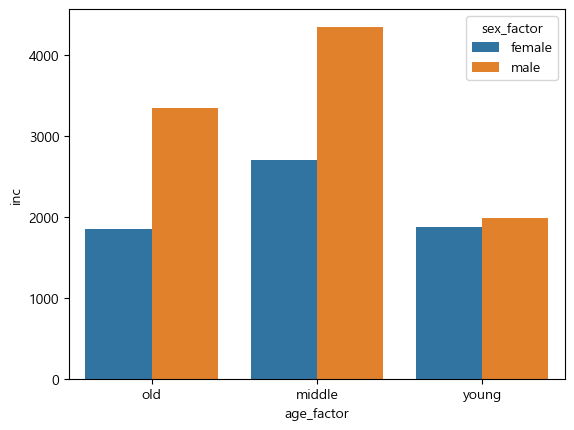

In [84]:
sns.barplot(data = inc_sex_age,
            x = 'age_factor',
            y = 'inc',
            hue = 'sex_factor',
            order = ['old', 'middle', 'young'])
plt.show()

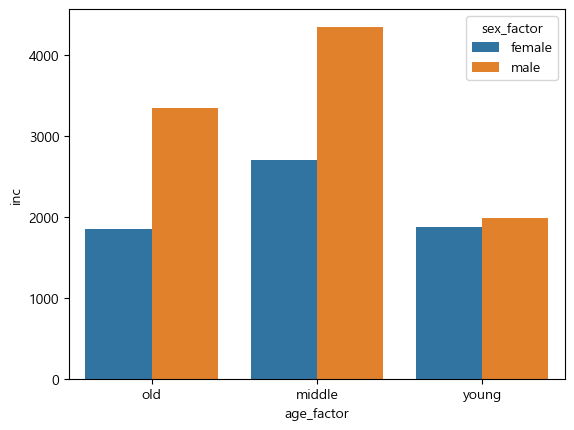

In [88]:
sns.barplot(data = inc_sex_age,
            x = 'age_factor',
            y = 'inc',
            hue = 'sex_factor',
            order = ['old', 'middle', 'young'])
plt.show()

In [112]:
inc_sex_age.reset_index()

,age_factor,sex_factor,inc
0,middle,female,2704.273927
1,middle,male,4353.504988
2,old,female,1857.361702
3,old,male,3346.445521
4,young,female,1876.902552
5,young,male,1984.196721


In [117]:
sex_age_inc_anova = ols('inc ~ C(age_factor) + C(sex_factor)', df2).fit()
print(anova_lm(sex_age_inc_anova))


                   df        sum_sq       mean_sq           F         PR(>F)
C(age_factor)     2.0  2.044161e+09  1.022081e+09  310.774248  1.573103e-128
C(sex_factor)     1.0  2.731828e+09  2.731828e+09  830.640769  4.024807e-170
Residual       5444.0  1.790434e+10  3.288820e+06         NaN            NaN


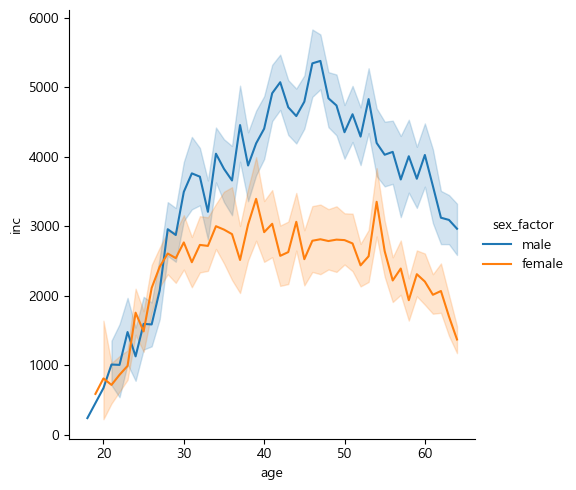

In [121]:
sns.relplot(x = 'age',
            y = 'inc', 
            hue = 'sex_factor',
            data = df2,
            kind = 'line')
plt.show()

# 직업별 월급차이

In [124]:
df2.job

3        855.0
4        399.0
8        151.0
9          NaN
12         NaN
         ...  
16244    153.0
16247    151.0
16248      NaN
16254    248.0
16255      NaN
Name: job, Length: 5448, dtype: float64

In [137]:
job_code = pd.read_excel('d:/song/python_practice/welfare/Koweps_Codebook.xlsx', sheet_name=1)
job_code

,code_job,job
0,111,의회의원 고위공무원 및 공공단체임원
1,112,기업고위임원
2,120,행정 및 경영지원 관리자
3,131,연구 교육 및 법률 관련 관리자
4,132,보험 및 금융 관리자
...,...,...
144,991,농립어업관련 단순 종사원
145,992,계기검침 수금 및 주차 관련 종사원
146,999,기타 서비스관련 단순 종사원
147,1011,장교


In [149]:
df3 = pd.merge(df2, job_code,
               how = 'left',
               left_on = 'job',
               right_on = 'code_job')

          

In [151]:
df3.rename(columns = {'job_x' : 'job', 
                      'job_y' : 'job_name'}, inplace = True)

In [163]:
df3.groupby('job_name')[['inc']].agg('mean').sort_values('inc', ascending = False).head(10)

,inc
job_name,
약사 및 한약사,7440.000000
법률 전문가,7200.000000
인사 및 경영 전문가,6919.500000
행정 전문가,6635.571429
화물열차 차장 및 관련 종사원,6580.000000
경찰 소방 및 교도 관련 종사자,6064.440000
컴퓨터 하드웨어 및 통신공학 전문가,6009.857143
정보통신관련 관리자,5873.250000
환경공학 기술자 및 시험원,5837.181818


In [164]:
df3.groupby('job_name')[['inc']].agg('mean').sort_values('inc', ascending = False).tail(10)

,inc
job_name,
기타 이미용 예식 및 의료보조 서비스 종사자,2029.750000
음식서비스 종사자,1966.949045
농립어업관련 단순 종사원,1944.250000
음식관련 단순 종사원,1937.000000
판매관련 단순 종사원,1876.707317
기타 서비스관련 단순 종사원,1675.544554
의료 복지 관련 서비스 종사자,1670.955556
작물재배 종사자,1294.288136
가사 및 육아 도우미,1123.333333


# 성별 직업빈도

In [171]:
df3.groupby(['sex_factor', 'job_name'])[['pid']].agg('count')

pid
sex_factor job_name                    
female     가사 및 육아 도우미               39
           간호사                       67
           건설 및 광업 단순 종사원             9
           건설 전기 및 생산 관련 관리자          1
           건축 및 토목 공학 기술자 및 시험원       4
...                                 ...
male       화학 고무 및 플라스틱 제품 생산기 조작원   10
           화학공학 기술자 및 시험원             2
           환경 청소 및 경비 관련 관리자          6
           환경공학 기술자 및 시험원            10
           회계 및 경리 사무원               59

[232 rows x 1 columns]

In [176]:
df3[df3['sex_factor'] == 'female'].groupby('job_name')[['pid']].count().sort_values('pid', ascending = False).head(10)

,pid
job_name,
회계 및 경리 사무원,176
매장 판매 종사자,153
의료 복지 관련 서비스 종사자,131
제조관련 단순 종사원,111
음식서비스 종사자,105
기타 교육 전문가,89
청소원 및 환경 미화원,87
주방장 및 조리사,82
고객 상담 및 기타 사무원,80


In [177]:
df3[df3['sex_factor'] == 'male'].groupby('job_name')[['pid']].count().sort_values('pid', ascending = False).head(10)

,pid
job_name,
경영관련 사무원,158
자동차 운전원,153
매장 판매 종사자,103
영업 종사자,90
제조관련 단순 종사원,83
건설 및 광업 단순 종사원,77
행정 사무원,77
전기 및 전자기기 설치 및 수리원,62
배달원,60
